In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm
import os
import cv2
sns.set_style('darkgrid')

In [2]:
train_dir="D:\\IEEEModel\\Train"
test_dir="D:\\IEEEModel\\Test"

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
      
        for filename in os.listdir(directory+"/"+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

,image,label
0,D:\IEEEModel\Train\Eco\2022012615084019-dry-as...,Eco
1,D:\IEEEModel\Train\Eco\2022012615204711-dry-as...,Eco
2,D:\IEEEModel\Train\Eco\2022012619360610-water-...,Eco
3,D:\IEEEModel\Train\Eco\2022012621281716-dry-co...,Eco
4,D:\IEEEModel\Train\Eco\2022012621281717-dry-co...,Eco


In [5]:
## convert into dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_dir)
test.head()

,image,label
0,D:\IEEEModel\Test\Eco\202201260012527-dry-asph...,Eco
1,D:\IEEEModel\Test\Eco\202201260012528-dry-asph...,Eco
2,D:\IEEEModel\Test\Eco\202201260012529-dry-asph...,Eco
3,D:\IEEEModel\Test\Eco\202201261342122-dry-asph...,Eco
4,D:\IEEEModel\Test\Eco\202201261454135-dry-asph...,Eco


In [6]:
train.columns

Index(['image', 'label'], dtype='object')

In [7]:
train

,image,label
0,D:\IEEEModel\Train\Eco\2022012615084019-dry-as...,Eco
1,D:\IEEEModel\Train\Eco\2022012615204711-dry-as...,Eco
2,D:\IEEEModel\Train\Eco\2022012619360610-water-...,Eco
3,D:\IEEEModel\Train\Eco\2022012621281716-dry-co...,Eco
4,D:\IEEEModel\Train\Eco\2022012621281717-dry-co...,Eco
...,...,...
80218,D:\IEEEModel\Train\Sports\347.jpg,Sports
80219,D:\IEEEModel\Train\Sports\348.jpg,Sports
80220,D:\IEEEModel\Train\Sports\350.jpg,Sports
80221,D:\IEEEModel\Train\Sports\351.jpg,Sports


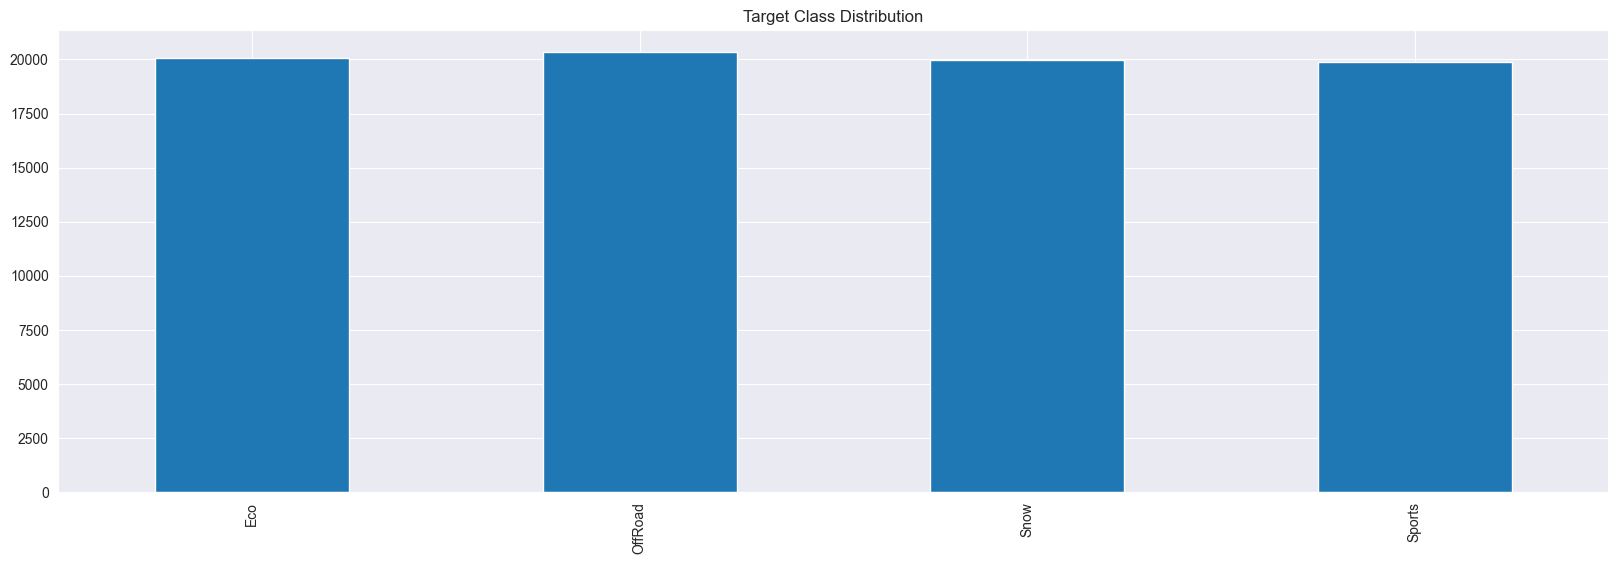

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer().fit(train.label.apply(lambda x: x.split()))
labels = pd.DataFrame(mlb.transform(train.label.apply(lambda x: x.split())), columns=mlb.classes_)

fig, ax = plt.subplots(figsize=(20, 6))
labels.sum().plot.bar(title='Target Class Distribution');

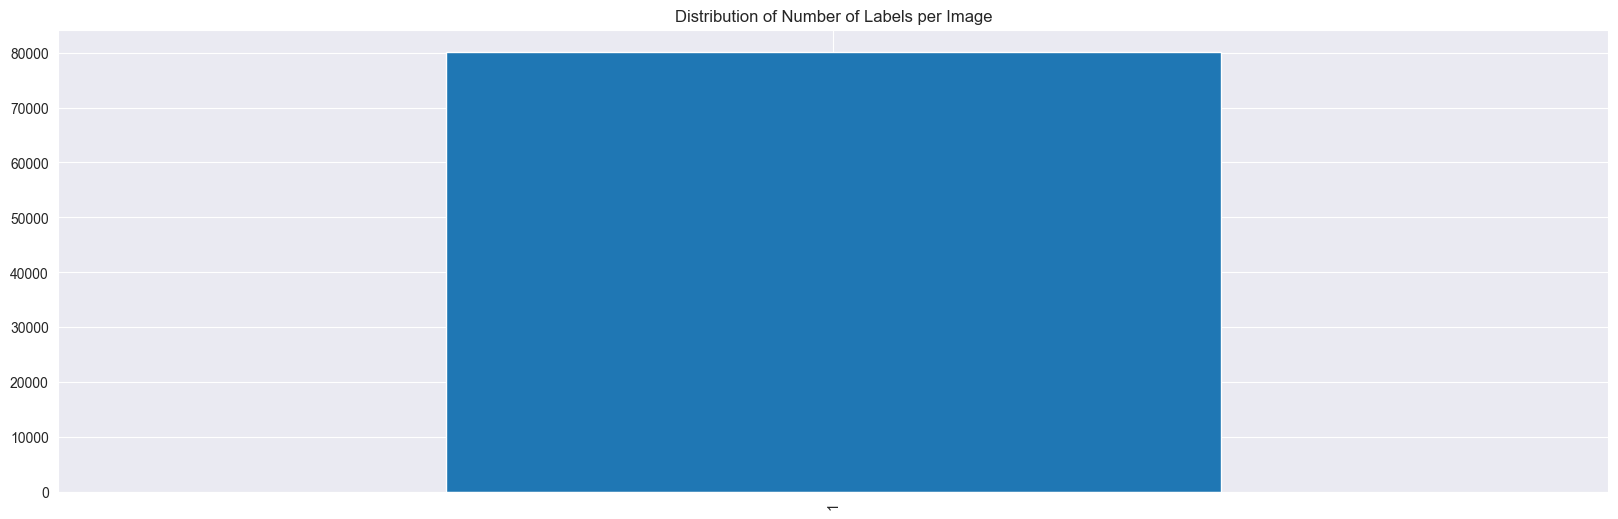

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
labels.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image');

In [10]:
labels = pd.concat([train['image'], labels], axis=1) #.drop('healthy', axis=1)
labels.head()

,image,Eco,OffRoad,Snow,Sports
0,D:\IEEEModel\Train\Eco\2022012615084019-dry-as...,1,0,0,0
1,D:\IEEEModel\Train\Eco\2022012615204711-dry-as...,1,0,0,0
2,D:\IEEEModel\Train\Eco\2022012619360610-water-...,1,0,0,0
3,D:\IEEEModel\Train\Eco\2022012621281716-dry-co...,1,0,0,0
4,D:\IEEEModel\Train\Eco\2022012621281717-dry-co...,1,0,0,0


In [11]:
batch_size=128
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=batch_size,
    subset='training'
)

valid_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='test_dir',
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=batch_size,
    subset='validation'
)

Found 72201 validated image filenames.
Found 8022 validated image filenames.


In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.MobileNetV2(include_top=False)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)
#model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 2,228,996
Non-trainable params: 34,112
_________________________________________________________________
You must install pydot (`pip install pydot`) a

In [13]:
type(train_generator)
type(valid_generator)

keras.preprocessing.image.DataFrameIterator

In [14]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.01)#
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[rlp, es])

Epoch 1/5
565/565 [==============================] - 7279s 13s/step - loss: 0.0902 - accuracy: 0.9314 - val_loss: 1.1472 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 2/5
565/565 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9615 
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
565/565 [==============================] - 7545s 13s/step - loss: 0.0517 - accuracy: 0.9615 - val_loss: 1.5484 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 3/5
565/565 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9764 
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-07.
565/565 [==============================] - 7746s 14s/step - loss: 0.0323 - accuracy: 0.9764 - val_loss: 1.9477 - val_accuracy: 0.3699 - lr: 1.0000e-05
Epoch 4/5
565/565 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9807 
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Restoring model weights fro

<Axes: title={'center': 'Model Loss Curve'}>

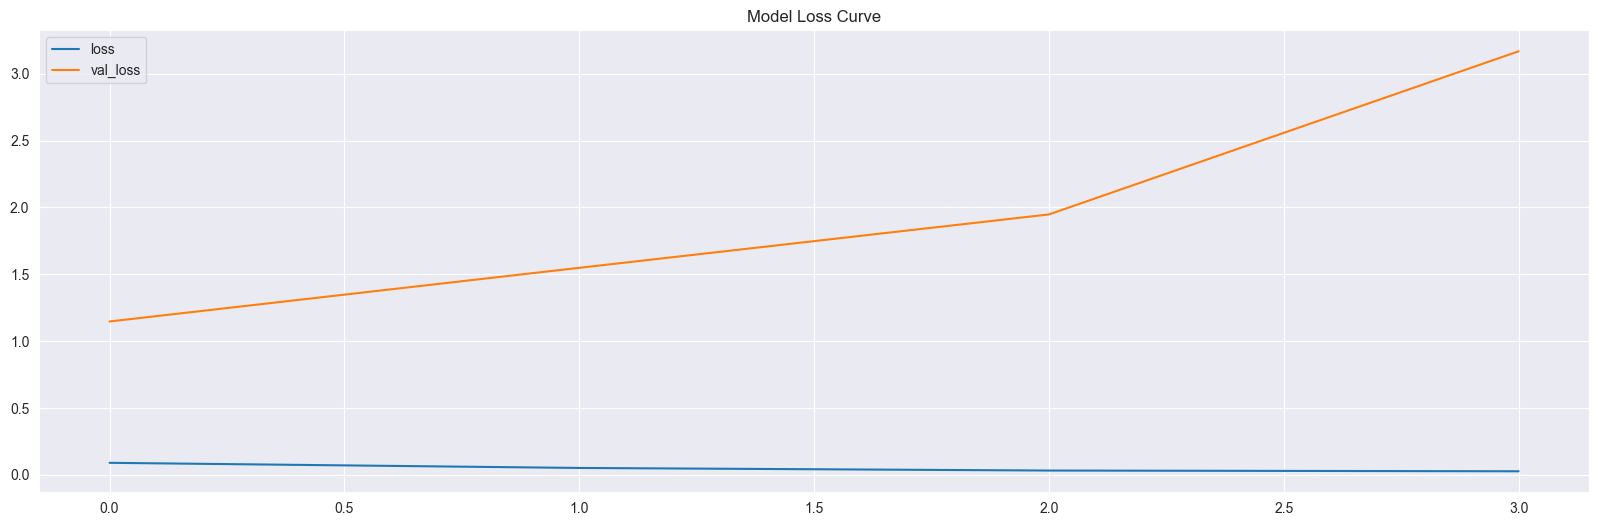

In [15]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

<Axes: title={'center': 'Model Accuracy Curve'}>

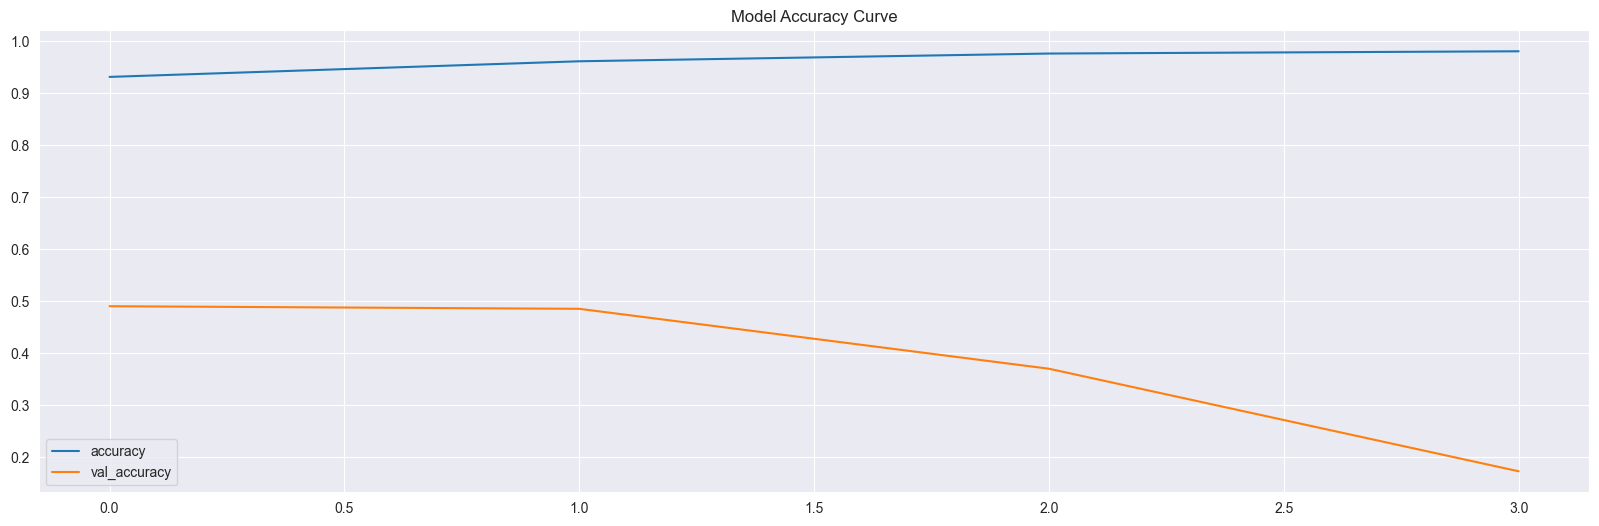

In [16]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax, title='Model Accuracy Curve')

In [17]:
l=pd.DataFrame(history.history)[["loss"]].min()
v_l=pd.DataFrame(history.history)[["val_loss"]].min()
a=pd.DataFrame(history.history)[["accuracy"]].max()
v_a=pd.DataFrame(history.history)[["val_accuracy"]].max()
print(l,v_l,a,v_a)

loss    0.026849
dtype: float64 val_loss    1.147164
dtype: float64 accuracy    0.980748
dtype: float64 val_accuracy    0.490152
dtype: float64


In [18]:
model.save('mobilenetv2modelNew.h5')